# Laboration Machine Learning AI21
## 1.1 - Movielens full - EDA 

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

In [2]:
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
def get_title(movieId):
    return df_movies.query('movieId == @movieId')['title'].item()

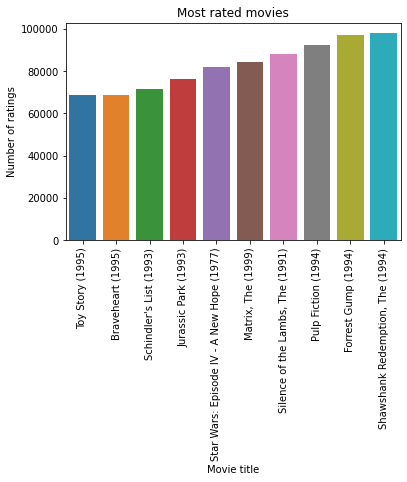

In [6]:
top10_most_rated = df_ratings["movieId"].value_counts()[:10]
top10_titles = []
for movie_id in top10_most_rated.index:
    top10_titles.insert(0, get_title(movie_id))

ax = sns.barplot(x=top10_most_rated, y=top10_most_rated)
ax.set(ylabel="Number of ratings", xlabel="Movie title", xticklabels=top10_titles, title="Most rated movies")
plt.xticks(rotation=90);

In [7]:
top10_mean_rating = df_ratings[df_ratings["movieId"].isin(top10_most_rated.index)]["rating"].mean()
print(f"The mean rating for the top 10 most rated movies is: {top10_mean_rating:.1f}")

The mean rating for the top 10 most rated movies is: 4.1


In [8]:
# found the extract code at https://stackoverflow.com/questions/57465105/python-pandas-str-extract-year-information-from-unclean-column
df_movies["year"] = df_movies["title"].str.extract(r'(18\d{2}|19\d{2}|20\d{2})')[0].dropna()

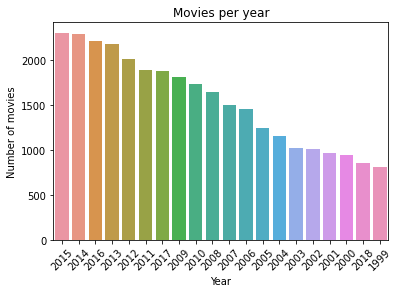

In [9]:
top20_year_movies =df_movies["year"].value_counts()[:20]

ax = sns.barplot(y=top20_year_movies, x=top20_year_movies.index)
ax.set(xlabel="Year", ylabel="Number of movies", title="Movies per year")
plt.xticks(rotation=45);

## 1.2 Create sparse matrix

In [78]:
len(df_ratings.value_counts())

27753444

In [79]:
len(df_ratings["movieId"].value_counts())

53889

There are a total of 27753444 ratings for 53889 movies

In [12]:
rating_count = df_ratings["movieId"].value_counts()
less_than_1000_ratings = rating_count[rating_count < 1000].index
movies_more_than_1000_ratings = df_ratings[~df_ratings["movieId"].isin(less_than_1000_ratings)]
print(f"Percentage of original data: {len(movies_more_than_1000_ratings['movieId']) / len(df_ratings['movieId']) * 100:.2f}%")

Percentage of original data: 89.73%


There are 49958 movies with less than 1000 ratings and those account for a total of 2849870 ratings, which is  about 10% of the total number of ratings. I will exclude those.

After removing those there are still 24903574 ratings which are still too many to create a sparse matrix (with my hardware).

In [13]:
mean_number_of_ratings = movies_more_than_1000_ratings["movieId"].value_counts().mean()
half_mean = rating_count[rating_count < mean_number_of_ratings / 2].index
removed_half_mean = df_ratings[~df_ratings["movieId"].isin(half_mean)]
print(f"Half of mean: {mean_number_of_ratings / 2:.2f}")
print(f"Percentage of original data: {len(removed_half_mean['movieId']) / len(df_ratings['movieId']) * 100:.2f}%")

Half of mean: 3167.59
Percentage of original data: 76.48%


In order to filter out more data I removed every movie that had less than 3167 ratings which is half of the mean number of ratings among the movies that had more than 1000 ratings. The remaning data is still 76% of the original data and it was possible to create a sparse matrix.

In [17]:
movie_users = removed_half_mean.pivot(index="movieId", columns="userId", values="rating").fillna(0)
movie_users_matrix = csr_matrix(movie_users.values)

## 1.3 Recommendation system

Creating a new list of movies that can be recommended since I removed some in 1.2

In [80]:
movies_in_recommendations = df_movies[df_movies["movieId"].isin(removed_half_mean["movieId"].unique())].reset_index()

Fitting model and recommendation function

In [201]:
model_KNN = NearestNeighbors(n_neighbors = 20, metric = "cosine", algorithm = "brute")
model_KNN.fit(movie_users_matrix)

def recommendations():
    user_input = input("Enter movie title: ")
    try:
        index = process.extractOne(user_input, movies_in_recommendations["title"], score_cutoff=90)[2]
        recommendations = model_KNN.kneighbors(movie_users_matrix[index], n_neighbors = 6)[1][0]

        print(f"Top 5 recommendations for: {movies_in_recommendations['title'][recommendations[0]]}")
        for movie_index in recommendations[1:]:
            print(movies_in_recommendations["title"][movie_index])
    except (TypeError):
        print(f"Sorry! Can't find {user_input} in database.")
    

In [202]:
recommendations()

Top 5 recommendations for: Jurassic Park (1993)
Terminator 2: Judgment Day (1991)
Forrest Gump (1994)
Speed (1994)
Fugitive, The (1993)
Batman (1989)


a)
This recommendation system finds 5 recommendations by using the K-Nearest Neighbors algorithm, which in this case finds the 5 closest movies based on movie ratings.

b) There seems to be two main ways to do recommendation systems Collaborative filtering methods and Content based methods. 

For collaborative filtering methods the recommendation is based on past interactions by the user and the accuracy gets better when the user have more interactions. The interactions from users are then used to recommend content to users that have interacted with similar content. This introduces a problem with new users and can be solved by recommending generally popular content.

Content based methods are based on the features of the content and the user, after collecting interactions from the user the recommendations are based on the features of the content and the recommendations will often be more specific. New users can be recommended stuff based on their features, such as gender and age.

source: https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada